In [1]:
# import the required python modules

import ceviche
import matplotlib.pylab as plt
import numpy as np
from numpy import pi, real, conj

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [2]:
# constants

EPSILON_0 = 8.85418782e-12              # vacuum permittivity
MU_0 = 1.25663706e-6                    # vacuum permeability
C_0 = 1 / np.sqrt(EPSILON_0 * MU_0)     # speed of light in vacuum
Q_e = 1.602176634e-19                   # funamental charge

## 2D Comsol cross-check

In [3]:
# parameters

################################################################################
# geometry

a = 200e-9          # grating period (in m)
F = 1.0             # grating fill factor
h = 175e-9          # grating tooth height
d = 20e-9           # impact parameter
base = 100e-9       # grating base height
xR_PML = 700e-9     # distance from the right PML to the bottom of the grating
xL_PML = 700e-9     # distance from the left PML to the electron path
detector = 100e-9   # separation between the detectors and the PMLs

################################################################################
# FD simulation parameters

dl = 2e-9            # element size (in m)
Npml = 20            # Size of the PML boundaries in pixels 

# Simulation domain size (in number of pixels)
Nx = int((xR_PML + xL_PML + base + h + d) / dl) + 2*Npml + 1
Ny = int(a / dl) + 1
   
################################################################################
# material

n = 3.91             # refractive index
val_epsr = n**2      # relative permittivity

################################################################################
# electron beam

beta = 0.32838       # electron relative velocity
sigma_x = 3e-9       # electron beam sigma_x  

################################################################################
# radiation

m = 1                   # spectral order
theta = (90)*pi/180     # radiation angle

# frequency from iSPR equation (in Hz):
# omega = 2*pi*m*beta*C_0 / (Ny*dl*(1-beta*n*np.cos(theta)))


omega = 600e12 * 2* pi  

################################################################################

In [4]:
print(f'Nx, Ny:\t\t{(Nx, Ny)}')
print(f'omega:\t\t{(omega):.2e}')

Nx, Ny:		(888, 100)
omega:		3.77e+15


In [5]:
# Initialize relative permittivity of the domain
epsr = np.ones((Nx, Ny))

#################################################
# grating for Smith-Purcell

x1 = Npml + int((xL_PML + d) / dl)
x2 = Npml + int((xL_PML + d + h) / dl)
y1 = int(Ny/2*(1-F))
y2 = int(Ny/2*(1-F) + F*Ny)
epsr[x2:Nx, 0:y1]  = val_epsr
epsr[x1:Nx, y1:y2] = val_epsr
epsr[x2:Nx, y2:Ny] = val_epsr
#################################################

# planar slab
# epsr[(hw+2*h):Nx, 0:Ny] = 6

design_region = np.ones((Nx, Ny))
design_region[0:x1, 0:Ny] = 0

<AxesSubplot:xlabel='x', ylabel='y'>

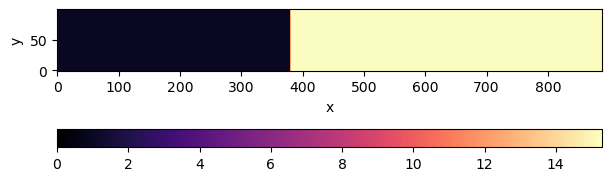

In [6]:
ceviche.viz.abs(epsr, cbar=True)
# ceviche.viz.abs(design_region, cbar=True)

In [7]:
def J(x, y, omega, v, sigma_x, d):
    '''Electric current density'''

    x *= dl
    y *= dl


    j = -Q_e / (4*pi * d) / np.sqrt(2*pi* sigma_x **2) * np.exp(-x**2/(2*sigma_x**2)) * np.exp(-1j * omega/v * y)
    
    return j

In [8]:
current = np.zeros((Nx, Ny), dtype=np.complex128)
for x in range(Nx):
    for y in range(Ny):
        current[x,y] = J(x - (Npml + xL_PML / dl), y, omega=omega, v=beta*C_0, sigma_x=sigma_x, d=0.5e-9)

<AxesSubplot:xlabel='x', ylabel='y'>

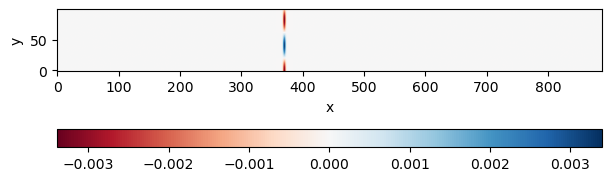

In [9]:
# ceviche.viz.abs(current, cbar=True)
ceviche.viz.real(current, cbar=True)

In [10]:
# Create the simulation object for 'Hz' (TM) polarization
simulation = ceviche.fdfd_hz(omega, dl, epsr, [Npml, 0], bloch_phases=[0, -(omega/(beta*C_0)*a)])

In [11]:
source_tmp = np.zeros((Nx, Ny), dtype=np.complex128)
source_tmp = np.reshape(simulation.Dxb.dot(current.flatten() / (-EPSILON_0 * 1j * omega)), (Nx, Ny))
source_tmp[design_region == 1] = 0

In [12]:
# ceviche.viz.abs(source_tmp, cbar=True)
# ceviche.viz.real(source_tmp, cbar=True)

In [13]:
# Run the simulation with the given source
Ex, Ey, Hz = simulation.solve(source_tmp)
Ey = Ey - current / (EPSILON_0 * 1j * omega)

<AxesSubplot:title={'center':'Hz'}, xlabel='x', ylabel='y'>

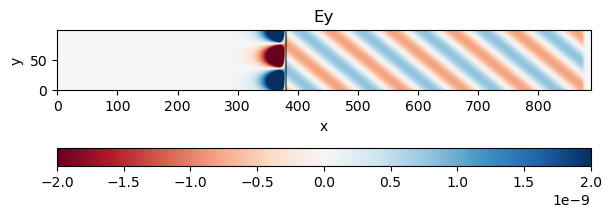

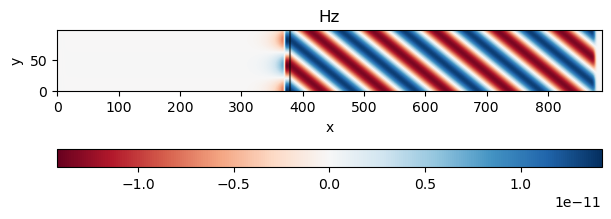

In [14]:
# Visualize the real value of the _ field component
ceviche.viz.real(Ey*np.exp(2*pi*1j*5/12), DK_max=2e-9, DK_title='Ey', outline=epsr, cbar=True)
ceviche.viz.real(Hz, DK_title='Hz', outline=epsr, cbar=True)

### Poynting vector

In [15]:
Sx =  4*2*pi * real( 1/2 * Ey * conj(Hz))
Sy =  4*2*pi * real(-1/2 * Ex * conj(Hz))

<AxesSubplot:title={'center':'Sy'}, xlabel='x', ylabel='y'>

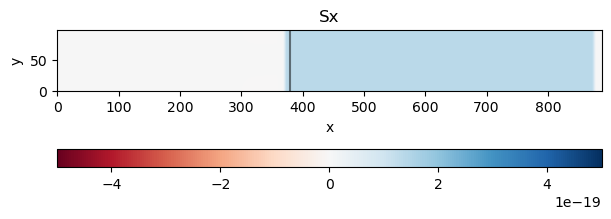

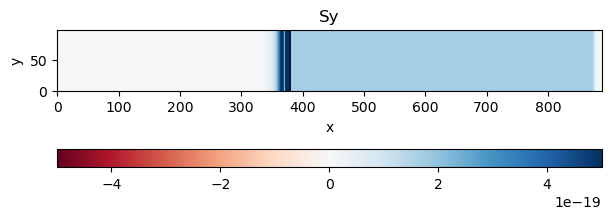

In [16]:
ceviche.viz.real(Sx, DK_max= 5e-19, DK_title='Sx', outline=epsr, cbar=True)
ceviche.viz.real(Sy, DK_max= 5e-19, DK_title='Sy', outline=epsr, cbar=True)

In [17]:
det_x = Nx - Npml - 40
print(f'det_x: \t{det_x}')

np.sum(Sx[det_x, :]) * a

det_x: 	828


2.731280338538211e-24

In [18]:
def freq(omega):
    '''The whole simulation in one function'''
    simulation = ceviche.fdfd_hz(omega, dl, epsr, [Npml, 0], bloch_phases=[0, -omega/(beta*C_0)*a])
    current = np.zeros((Nx, Ny), dtype=np.complex128)
    for x in range(Nx):
        for y in range(Ny):
            current[x,y] = J(x - (Npml + xL_PML / dl), y, omega=omega, v=beta*C_0, sigma_x=sigma_x, d=0.5e-9)
    source_tmp = np.zeros((Nx, Ny), dtype=np.complex128)
    source_tmp = np.reshape(simulation.Dxb.dot(current.flatten() / (-EPSILON_0 * 1j * omega)), (Nx, Ny))
    source_tmp[design_region == 1] = 0
    Ex, Ey, Hz = simulation.solve(source_tmp)
    Ey = Ey - current / (EPSILON_0 * 1j * omega)
    Sx =  4*2*pi * real( 1/2 * Ey * conj(Hz))
    # Sy =  4*2*pi * real(-1/2 * Ex * conj(Hz))
    return np.sum(Sx[det_x, :]) * a

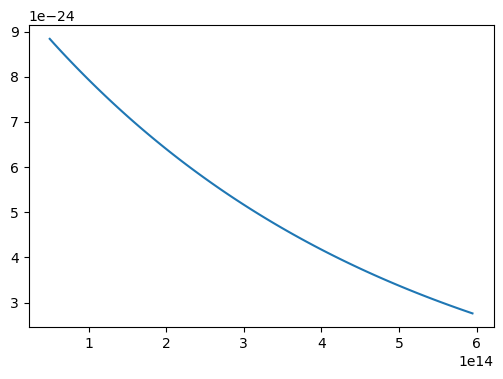

In [19]:
# spectrum
freq_list = [freq(f*2*pi) for f in np.arange(50e12, 600e12, 5.5e12)]
plt.plot(np.arange(50e12, 600e12, 5.5e12), freq_list)